# Benson Project:  Cat Meets Coffee

We are trying to do some data analysis to help us offer suggestions to a cat cafe owner who wants to find new locations for prospective cat cafe businesses.  To do this, we:

1. Load in the MTA Turnstile data, use it to estimate the amount of foot traffic for the area near the station.  We will split thus up tracers of weekend and weekday foot traffic.

2. Load in Inspections data on businesses in NYC, filter down to places with PET in the name.  This give us a proxy for the distribution of locations of pet stores in NYC.  This will help us answer where there are pet lovers in NYC.

3. We will then load this data into a scatter plot of weekday traffic vs number of pet stores nearby.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import re
from datetime import datetime as dt
import math
import datetime

sns.set()


#set display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 3)

---
# Load in the Past 13 Weeks of Turnstile Data

Retrieve data. Save as DataFrame df. 

In [2]:
def load_mta_data(num_weeks=3):
    try:
        df = pd.read_csv(f"mta_{num_weeks}week_data.csv")
    except FileNotFoundError:
        print("No local data. Gathering data from web.  May take a few moments...")
        df = scrape_mta_data(num_weeks)

    return df


def scrape_mta_data(num_weeks=3):
   # Download data files from web.mta.info website.
    STOP_DATE = datetime.datetime(2018, 6, 30)
    WEEK = datetime.timedelta(days=7)
    URL = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

    dfs = []
    for i in range(num_weeks):
        full_url = URL + (STOP_DATE - i*WEEK).strftime('%y%m%d') + ".txt"
        dfs.append(pd.read_csv(full_url))

    df = pd.concat(dfs)
    # Clean and pickle data.
    df.columns = [col.strip() for col in df.columns]
    df.to_csv(f"mta_{num_weeks}week_data.csv")

    return df

In [3]:
df = load_mta_data(13)

Fix the faulty column name "EXIT      " to "EXIT":

In [4]:
df.rename(columns={df.columns[-1]:'EXITS'}, inplace=True)
df.columns

Index(['Unnamed: 0', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

---
# Processing Data and Extracting Information from the Data

Here we will fix up the data and make columns for the information we actually need to get at (i.e. relative entrance and exit data, etc).

In [5]:
df['DATE_TIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901,2018-06-23 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909,2018-06-23 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938,2018-06-23 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006,2018-06-23 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066,2018-06-23 16:00:00


In [6]:
df = df[df.DESC=='REGULAR'] #remove record with 'RECOV AUD'
df = df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME','DATE_TIME'])
df.drop(columns='DESC', inplace = True)

daily_turnstile = \
df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], 
           as_index=False)[['ENTRIES','EXITS']].first()

daily_turnstile[['PREV_DATE', 'PREV_ENTRIES', 'PREV_EXITS']] = (daily_turnstile
                                                                    .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME'])['DATE', 'ENTRIES', 'EXITS']
                                                                .transform(lambda g: g.shift(1)))
daily_turnstile.dropna(subset=['PREV_DATE'], inplace=True)

The MTA turnstile data contains only cummulative records, so we need to push this down to the relative records, i.e. how many exits and entrances actually occurred on that day.

In [7]:
def get_daily_counts(row, max_counter = 10000):
    '''Remove rows with missing data. Correct negative values and values from device reset.
    '''
    enter_counter = row.ENTRIES - row.PREV_ENTRIES
    exit_counter = row.EXITS - row.PREV_EXITS
    if enter_counter < 0:
        enter_counter = -enter_counter
    if enter_counter > max_counter:
        #print('enter', row["ENTRIES"], row["PREV_ENTRIES"])
        enter_counter = min(row.ENTRIES, row.PREV_ENTRIES)
    if enter_counter > max_counter:
        enter_counter = 0
    if exit_counter < 0:
        exit_counter = -exit_counter
    if exit_counter > max_counter:
        #print('exit', row["EXITS"], row["PREV_EXITS"])
        exit_counter = min(row.EXITS, row.PREV_EXITS)
    if exit_counter > max_counter:
        exit_counter = 0
    return enter_counter, exit_counter

In [8]:
daily_turnstile['DAILY_ENTRIES'], daily_turnstile['DAILY_EXITS'] = zip(*daily_turnstile
                                                      .apply(get_daily_counts, axis = 1, max_counter=10000))

Add a column TRAFFIC, which is the sum of daily entries and exits.

In [9]:
daily_turnstile['TRAFFIC'] = daily_turnstile.DAILY_ENTRIES + daily_turnstile.DAILY_EXITS


The same station may have linenames in different orders. For example, in the original data set, FULTON ST has 3 linenames: 'ACJZ2345', '2345ACJZ' and 'G'. G is in Brooklyn, but'ACJZ2345' and '2345ACJZ' should refer to the same station. Sort the lines in the linename will solve the different linename due to the different order.

In [10]:
daily_turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,04/01/2018,6566470,2224055,03/31/2018,6.566e+06,2.224e+06,7.0,5.0,12.0
2,A002,R051,02-00-00,59 ST,NQR456W,04/02/2018,6566470,2224055,04/01/2018,6.566e+06,2.224e+06,0.0,0.0,0.0
3,A002,R051,02-00-00,59 ST,NQR456W,04/03/2018,6567630,2224496,04/02/2018,6.566e+06,2.224e+06,1160.0,441.0,1601.0
4,A002,R051,02-00-00,59 ST,NQR456W,04/04/2018,6568921,2225039,04/03/2018,6.568e+06,2.224e+06,1291.0,543.0,1834.0
5,A002,R051,02-00-00,59 ST,NQR456W,04/05/2018,6570307,2225512,04/04/2018,6.569e+06,2.225e+06,1386.0,473.0,1859.0


In [11]:
daily_turnstile.LINENAME = daily_turnstile.LINENAME.apply(lambda name: ''.join(sorted(name)))

Separate weekday and weekends to two DataFrames, starting from Mon.

In [12]:
daily_turnstile['date'] = pd.to_datetime(daily_turnstile.PREV_DATE)
daily_turnstile.set_index('date', inplace=True)
weekend = daily_turnstile[(daily_turnstile.index.weekday ==  5)|(daily_turnstile.index.weekday == 6)]

weekday = daily_turnstile[~((daily_turnstile.index.weekday ==  5)|(daily_turnstile.index.weekday == 6))]

print(daily_turnstile.shape, weekday.shape, weekend.shape)

(422548, 14) (300489, 14) (122059, 14)


In [13]:
weekday_daily = weekday.groupby(['STATION', 'LINENAME', 'DATE'], as_index=False)['DAILY_ENTRIES', 'DAILY_EXITS','TRAFFIC'].sum()
weekend_daily = weekend.groupby(['STATION', 'LINENAME', 'DATE'], as_index=False)['DAILY_ENTRIES', 'DAILY_EXITS','TRAFFIC'].sum()

weekday_station = weekday_daily.groupby(['STATION', 'LINENAME'], as_index=False).sum()
weekend_station = weekend_daily.groupby(['STATION', 'LINENAME'], as_index=False).sum()

In [14]:
weekday_station.rename(columns={'DAILY_ENTRIES':'ENTRIES_3M', 'DAILY_EXITS':'EXITS_3M'}, inplace=True)
weekend_station.rename(columns={'DAILY_ENTRIES':'ENTRIES_3M', 'DAILY_EXITS':'EXITS_3M'}, inplace=True)

In [15]:
weekday_station_total = weekday_station.sort_values('TRAFFIC', ascending=False)
weekday_station_total['TRAFFIC_rank'] = weekday_station_total.TRAFFIC.rank(ascending=False)
weekend_station_total = weekend_station.sort_values('TRAFFIC', ascending=False)
weekend_station_total['TRAFFIC_rank'] = weekend_station_total.TRAFFIC.rank(ascending=False)

---
# Import MTA station location data from NYC opendata.

* Here we load up the MTA station data, which contains the location for MTA stations.  The only issue is that it conflicts with the naming conventions, so we won't be able to extract all of them systematically.  However, our analysis will give us at least the top 200 trafficked stations, so this is adequate.

* We will use this later to compare to the location of pet stores.

In [16]:
location = pd.read_csv('DOITT_SUBWAY_STATION_01_13SEPT2010.csv')

location.drop(columns = ['URL','OBJECTID','NOTES'],inplace = True)

In [17]:
location['NAME'] = location.NAME.str.upper()

__N.B.__ Naming conflicts abound, so we will work towards removing the obvious naming inconsistencies.

In [18]:
def streetname(s):
    '''Try to uniform the format of the station names
    '''
    s = re.sub('AVE', 'AV', s)
    s = re.sub('AVNUE', 'AV', s)
    s = re.sub('(\d+)[A-Z]{2}', r'\1', s)
    s = re.sub('\s-\s', '-', s)
    s = re.sub('/', '-', s)
    s = re.sub('(\d+\s)[A-Z]{2}-(\w+)\s*\w*', r'\1\2', s)
    s = re.sub('-', ' ', s)
    return s

In [19]:
location['NAME']= location.NAME.transform(streetname)

In [20]:
location.head()

,NAME,the_geom,LINE
0,ASTOR PL,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express
1,CANAL ST,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express
2,50 ST,POINT (-73.98384899986625 40.76172799961419),1-2
3,BERGEN ST,POINT (-73.97499915116808 40.68086213682956),2-3-4
4,PENNSYLVANIA AV,POINT (-73.89488591154061 40.66471445143568),3-4


Split the coordinates in different columns, to aid in processing distances.

In [21]:
def split_coordinate(s):
    sl = s.split()
    #return (sl[1], sl[2])
    lon = float(sl[1].strip('('))
    lat = float(sl[2].strip(')'))
    return (lon, lat)

split_coordinate('POINT (-73.99106999861966 40.73005400028978)') #test

(-73.99106999861966, 40.73005400028978)

In [22]:
location['lon'], location['lat'] = zip(*location.the_geom.apply(split_coordinate))
location.head()

,NAME,the_geom,LINE,lon,lat
0,ASTOR PL,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,-73.991,40.730
1,CANAL ST,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,-74.000,40.719
2,50 ST,POINT (-73.98384899986625 40.76172799961419),1-2,-73.984,40.762
3,BERGEN ST,POINT (-73.97499915116808 40.68086213682956),2-3-4,-73.975,40.681
4,PENNSYLVANIA AV,POINT (-73.89488591154061 40.66471445143568),3-4,-73.895,40.665


We notice there slightly different location for same station, for example, FULTON ST.

__N.B.__ We take average for those ones that are close!  This is an assumption to help us aggregate some of the stations that are very close so we don't get too many stations that are right next to each other and sampling the same nearby pet storess.

In [23]:
location[location.NAME == 'FULTON ST']

,NAME,the_geom,LINE,lon,lat
117,FULTON ST,POINT (-73.97537499833149 40.68711899950771),G,-73.975,40.687
359,FULTON ST,POINT (-74.00762309323994 40.71016216530185),A-C,-74.008,40.710
401,FULTON ST,POINT (-74.00657099970202 40.70941599925865),2-3,-74.007,40.709
412,FULTON ST,POINT (-74.00793800110387 40.71002266658424),J-Z,-74.008,40.710
426,FULTON ST,POINT (-74.00950899856461 40.710367998822136),4-5,-74.010,40.710


In [24]:
location = location[~((location.NAME =='FULTON ST') & (location.LINE == 'G'))]

In [25]:
location_station= location.groupby('NAME')['lon','lat'].mean()

---
# Make a DataFrame with all the station and coordinates

We will need it to calculate nearby petshops and the map to the turnstile data.

In [26]:
station = pd.DataFrame({'STATION': weekday_station.STATION.unique() })
station['alias'] = station.STATION.apply(streetname)
station_with_coordinates = pd.merge(station, 
                                         location_station, 
                                         left_on='alias', right_index=True, how='left')
station_with_coordinates.to_csv('station_names_coor.csv')

__N.B.__ We cleaned up some station names and coordinate and imported the csv back to the notebook.

In [46]:
location_station = pd.read_csv('station_names_coor.csv')

In [47]:
location_station[location_station.STATION == '2 AV']

,Unnamed: 0,STATION,alias,lon,lat
77,77,2 AV,2 AV,-73.99,40.723


In [48]:
location_station = location_station[['STATION','lon','lat']].set_index('STATION')
location_station.head()

,lon,lat
STATION,,
GRD CNTRL-42 ST,-73.977,40.752
34 ST-HERALD SQ,-73.988,40.750
14 ST-UNION SQ,-73.990,40.735
FULTON ST,-74.008,40.710
TIMES SQ-42 ST,-73.987,40.755


---
# Count the Number of Pet Stores near each Station

__N.B.__ For the interested reader:

Formula used to  calculate the distance of the longitude and lattitude data:  
Haversine formula:    
a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)  
c = 2 ⋅ atan2( √a, √(1−a) )  
d = R ⋅ c  
where    φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);  
note that angles need to be in radians to pass to trig functions!  

In [49]:
def to_radians(p):
    '''Convert degrees to radians.
    '''
    lon, lat = p
    return (lon*math.pi/180, lat*math.pi/180)        

p1 = (-73.82758075034528, 40.58326843810286)
p2 = (-73.81583268782963, 40.60840218069683)

def to_distance(p1,p2, r=6371e3):
    '''Calculate the distance between two coordinates in radians.
    '''
    lon1, lat1 = to_radians(p1)
    lon2, lat2 = to_radians(p2)
    dlat = lat1 - lat2
    dlon = lon1 - lon2
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*(math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return r*c   

Retrieve and process petshop data

In [50]:
df_pet = pd.read_csv('Inspections.csv')
retail = df_pet[df_pet['Industry'] == 'Misc Non-Food Retail - 817']
#filter for non-food retail, category of pet stores
retail2 = retail.dropna(subset=['Business Name'])
print(len(retail), len(retail2))
has_pet = retail2['Business Name'].str.contains('PET')
pet_names = retail2[has_pet]
pet_names.sample(20)
carpet_out = pet_names['Business Name'].str.contains('CARPET')
pet_names2 = pet_names[~carpet_out]
petroleum = pet_names2['Business Name'].str.contains('PETROLEUM')
pet_names3 = pet_names2[~petroleum]
other_pet_strings = pet_names3['Business Name'].str.contains('PETER|COMPETITIVE|MASPETH|PETIT')
pet_names4 = pet_names3[~other_pet_strings]
pet_names4.sample(20)
in_business = pet_names4['Inspection Result'].str.contains('Pass|No Violation Issued')
names_in_business = pet_names4[in_business]
len(names_in_business)
pet_store_addresses = names_in_business[['Business Name', 'Longitude', 'Latitude']]
pet_store_addresses.head()
#pet_store_addresses.to_csv('pet_stores.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


16202 16201


,Business Name,Longitude,Latitude
821,THE PET MARKET INC,-73.983,40.779
1730,"420 EAST 14TH STREET PET SUPPLY, CORP",-73.982,40.731
2702,"NATIONAL PET SUPPLY, INC",-73.867,40.898
2976,"PETLAND DISCOUNTS, INC.",-73.754,40.679
3268,"PETLAND DISCOUNTS, INC.",-73.994,40.602


In [51]:
petshop = pd.read_csv('pet_stores.csv')
petshop = petshop[['Longitude','Latitude']]

__Finally__, calculate nearby petshops for each station.

In [52]:
petshop_location = np.asarray(petshop)

def petshop_distance(p1, petshop_location, radius=600):
    '''calculate the number of petshop within a given radius (in meters) of the station.
    '''
    count = 0
    for location in petshop_location:
        #print(p1, location)
        #print(to_distance(p1, location) )
        if to_distance(p1, location) < radius:
            #print(to_distance(p1, location))
            count += 1
    return count
                
def get_counts(row):
    p = (row[0], row[1])
    return petshop_distance(p, petshop_location)
        

In [53]:
station_with_petshops = location_station.apply(get_counts, axis=1)
petshop_count = pd.DataFrame(station_with_petshops.sort_values(ascending = False))

In [54]:
weekend_station_total['station_line']=(weekend_station_total.STATION 
                                       + weekend_station_total.LINENAME)

weekday_station_total['station_line']=(weekday_station_total.STATION 
                                       + weekday_station_total.LINENAME)

Merge traffic DataFrame with nearby Petshop DataFrame

In [55]:
final = pd.merge(weekday_station_total[['STATION','LINENAME', 'TRAFFIC','station_line']], 
                weekend_station_total[['TRAFFIC','station_line']], 
                 on='station_line',suffixes=('weekday', 'weekend'), how='left')

In [56]:
final_petshop = pd.merge(final, petshop_count, left_on='STATION', right_index=True, how='left')

In [57]:
final_petshop.rename(columns={0:'petshop'},inplace=True)
final_petshop.head()



,STATION,LINENAME,TRAFFICweekday,station_line,TRAFFICweekend,petshop
0,GRD CNTRL-42 ST,4567S,1.881e+07,GRD CNTRL-42 ST4567S,2.704e+06,1
1,34 ST-HERALD SQ,BDFMNQRW,1.537e+07,34 ST-HERALD SQBDFMNQRW,3.181e+06,0
2,14 ST-UNION SQ,456LNQRW,1.273e+07,14 ST-UNION SQ456LNQRW,3.282e+06,2
3,FULTON ST,2345ACJZ,1.125e+07,FULTON ST2345ACJZ,1.618e+06,2
4,TIMES SQ-42 ST,1237ACENQRSW,1.091e+07,TIMES SQ-42 ST1237ACENQRSW,2.438e+06,0


In [58]:
final_petshop['weekend_traffic_r'] = final_petshop['TRAFFICweekend'].rank(ascending=False)
final_petshop['weekday_traffic_r'] = final_petshop['TRAFFICweekday'].rank(ascending=False)

In [59]:
final_petshop=final_petshop[['STATION', 'LINENAME','TRAFFICweekday',
                             'weekday_traffic_r', 'TRAFFICweekend', 'weekend_traffic_r', 'petshop']]
final_petshop.head(10)

,STATION,LINENAME,TRAFFICweekday,weekday_traffic_r,TRAFFICweekend,weekend_traffic_r,petshop
0,GRD CNTRL-42 ST,4567S,1.881e+07,1.0,2.704e+06,3.0,1
1,34 ST-HERALD SQ,BDFMNQRW,1.537e+07,2.0,3.181e+06,2.0,0
2,14 ST-UNION SQ,456LNQRW,1.273e+07,3.0,3.282e+06,1.0,2
3,FULTON ST,2345ACJZ,1.125e+07,4.0,1.618e+06,10.0,2
4,TIMES SQ-42 ST,1237ACENQRSW,1.091e+07,5.0,2.438e+06,5.0,0
5,34 ST-PENN STA,ACE,9.968e+06,6.0,2.147e+06,6.0,0
6,42 ST-PORT AUTH,1237ACENQRSW,9.823e+06,7.0,2.443e+06,4.0,1
7,59 ST COLUMBUS,1ABCD,8.580e+06,8.0,2.001e+06,7.0,3
8,47-50 STS ROCK,BDFM,7.829e+06,9.0,5.939e+05,52.0,0
9,PATH NEW WTC,1,7.266e+06,10.0,8.082e+05,27.0,0


In [60]:
final_petshop['weekday_average']=final_petshop.TRAFFICweekday/5/13

final_petshop['weekend_average']=final_petshop.TRAFFICweekend/2/13

In [61]:
p75 = final_petshop.weekday_average.quantile(0.75)
p75

25615.438461538462

In [62]:
#remove the stations that don't have coordinates
station_to_keep = location_station[location_station.lon.notnull()]

station_to_keep

df1 = final_petshop[final_petshop.STATION.isin(station_to_keep.index)]

---
# Plotting Weekday Foot Traffic vs Number of Pet Stores

Now we get to plot the data and see what results we get.

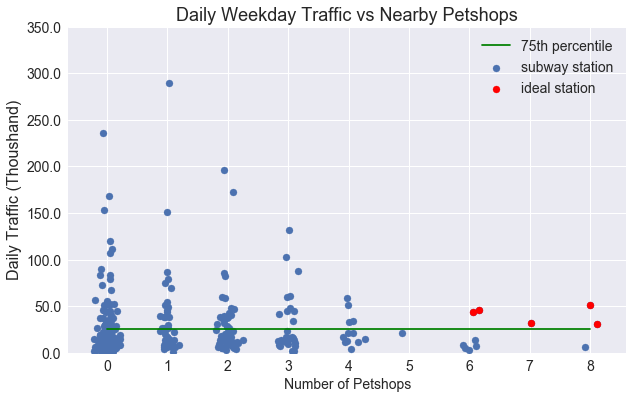

In [63]:
df1 = df1[['petshop', 'weekday_average']]
plotmask1 = ((df1.petshop>5) & (df1.weekday_average>p75))
df1['petshop_jitter'] = df1.petshop + np.random.randn(len(df1))/12

plt.figure(figsize=(10,6))

plt.scatter(df1['petshop_jitter'], df1.weekday_average)
plt.scatter(df1[plotmask1]['petshop_jitter'], df1[plotmask1]['weekday_average'], color='r')
plt.plot(np.linspace(0,8,3), [p75] *3, color = 'g')
loc, _ = plt.yticks()
lab = loc/1e3
plt.yticks(loc, lab, fontsize=14)
plt.ylabel('Daily Traffic (Thoushand)', fontsize = 16)
plt.ylim(0,350000)
plt.xticks(range(9), range(9), fontsize=14)
plt.xlabel('Number of Petshops', fontsize = 14)
plt.title('Daily Weekday Traffic vs Nearby Petshops',fontsize = 18)
plt.legend(['75th percentile','subway station','ideal station'], fontsize=14 );

In [64]:
final_petshop[final_petshop.petshop >5].head(5)

,STATION,LINENAME,TRAFFICweekday,weekday_traffic_r,TRAFFICweekend,weekend_traffic_r,petshop,weekday_average,weekend_average
36,50 ST,1,3.344e+06,37.0,639927.0,43.0,8,51440.677,24612.577
46,1 AV,L,2.982e+06,47.0,909037.0,22.0,6,45870.215,34962.962
55,DELANCEY/ESSEX,FJMZ,2.849e+06,56.0,670426.0,35.0,6,43833.185,25785.615
88,2 AV,F,2.105e+06,89.0,378785.0,107.0,7,32383.323,14568.654
92,50 ST,CE,2.043e+06,93.0,566032.0,59.0,8,31427.523,21770.462
